# Market basket analysis for ADSP


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.neighbors import KNeighborsClassifier
from chord import Chord
from wordcloud import WordCloud, STOPWORDS
from PIL import Image



plt.style.use('seaborn-darkgrid')
color = sns.color_palette()
%matplotlib inline

## Load data


In [2]:
# Reading all the datasets from the csv_src folder
csv_folder = 'csv_src/'
aisle = pd.read_csv( csv_folder+'aisles.csv')
orders = pd.read_csv(csv_folder+'orders.csv')
products = pd.read_csv(csv_folder+'products.csv')
departments = pd.read_csv( csv_folder+'departments.csv')
order_prior = pd.read_csv(csv_folder+'order_products__prior.csv') 
order_train = pd.read_csv(csv_folder+'order_products__train.csv')

## Preprocess data

In [3]:
orders.set_index('order_id', inplace=True)
products.set_index('product_id', inplace=True)
aisle.set_index('aisle_id', inplace=True)
departments.set_index('department_id', inplace=True)
orders = orders.fillna(0) # Setting the NaNs to 0. i.e. sets the days since order to 0 for 1st orders

## Explore data

In [4]:
orders.head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
2539329,1,prior,1,2,8,0.0
2398795,1,prior,2,3,7,15.0
473747,1,prior,3,3,12,21.0
2254736,1,prior,4,4,7,29.0
431534,1,prior,5,4,15,28.0


## Helper functions to generate histogram and bar plots

In [4]:
def hist_count_plots(dframe, x_axis, _title, _xlabel, _ylabel, color_index, fig_size=(15,8), title_size=24):
   
    plt.figure(figsize=fig_size)
    sns.countplot(x=x_axis, data=dframe, color=color[color_index])
    plt.title(_title, fontsize=title_size)
    plt.xlabel(_xlabel, fontsize=13)
    plt.ylabel(_ylabel, fontsize=13)
    # Setting the x tick label sizes
    if x_axis == "Order_count":
        plt.tick_params(axis='both', which='major', labelsize=12)
    else:
        plt.tick_params(axis='both', which='major', labelsize=16)
    
    if x_axis == "order_dow":
        plt.xticks( [0,1,2,3,4,5,6],["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"] )
    plt.show()   

def bar_plot(dframe, _xlabel, _ylabel, _title, fig_size=(22,8), title_size=18, vertical=False,):
    my_colors = [(x/10.0, x/20.0, 0.75) for x in range(len(dframe))]
    my_colors = ['g', 'b']
    dframe.plot.barh( figsize=fig_size, color=my_colors,stacked=True)
    plt.xlabel(_xlabel, fontsize=14)
    plt.ylabel(_ylabel, fontsize=14)

    plt.tick_params(axis='both', which='major', labelsize=17)
    plt.xticks()
    plt.title(_title, fontsize=title_size)

## Join orders with products

In [5]:
product_order = order_prior.iloc[0:50000,:].set_index('product_id').join(products, how="inner")
product_order.head(10000)

,order_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
product_id,,,,,,
1,1107,7,0,Chocolate Sandwich Cookies,61,19
3,2998,6,1,Robust Golden Unsweetened Oolong Tea,94,7
10,1532,18,1,Sparkling Orange Juice & Prickly Pear Beverage,115,7
23,791,4,0,Organic Turkey Burgers,49,12
23,4603,33,0,Organic Turkey Burgers,49,12
...,...,...,...,...,...,...
11193,2181,7,0,Ancient Grain Blueberry Hemp Granola,57,14
11193,4660,2,1,Ancient Grain Blueberry Hemp Granola,57,14
11195,1570,7,0,Unsweet Strawberry Kiwi Sparkling Water,115,7


In [6]:
# find most popular products
product_comb = products.reset_index().set_index('department_id').join(departments, how="inner")
product_comb = product_comb.reset_index().set_index('aisle_id').join(aisle, how="inner")
product_comb = product_comb.reset_index().set_index('product_id')
product_comb.sort_index(axis=0, ascending=True, kind='quicksort', inplace=True)
product_prior_comb = order_prior.set_index('product_id').join(product_comb, how="inner")
product_count_df = product_prior_comb.groupby('product_name').product_name.count()
product_count_df = product_count_df.to_frame()
product_count_df = product_count_df.iloc[0:50000,:].rename(columns={'product_name': 'Order_count'})
desc_product_count_df = product_count_df.sort_values(by=['Order_count'], ascending=False)
popular_prods = list(desc_product_count_df.index.values)[:7]

products_string = {}

for index, row in product_order.iterrows():
    if row['product_name'] in popular_prods:
        if row['product_name'] not in products_string:
            products_string[row['product_name']] = [row['order_id']]
        else:
            products_string[row['product_name']].append(row['order_id'])

maximum = 0
for key, value in products_string.items():
    temp = max(value)
    if temp > maximum:
        maximum = temp
        
new_dic = {}
for key,value in products_string.items():
    new_row = [0 for _ in range(maximum+1)]
    for el in value:
        new_row[el] = 1
    new_dic[key] = new_row

products_for_string = pd.DataFrame.from_dict(new_dic)
products_for_string.head(200)


,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Banana,Organic Hass Avocado,Large Lemon,Organic Avocado
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
195,1,0,0,0,0,0,0
196,0,1,0,0,0,0,0
197,0,1,0,0,0,0,0
198,0,0,0,1,0,0,0


## Function for making chord plot

In [49]:
def chord_plot(df, column_labels, width):# Now, matrix contains a 6x6 matrix of the values.
    matrix = df.corr()
    matrix[matrix == 100] = 0
    # Replacing negative values with 0’s, as features can be negatively correlated.
    matrix[matrix < 0] = 0
    np.fill_diagonal(matrix.values,0)
    # Multiplying all values by 100 for clarity, since correlation values lie b/w 0 and 1.
    matrix = matrix.multiply(100).astype(int)
    # Converting the DataFrame to a 2D List, as it is the required input format.
    matrix = matrix.values.tolist()
    names = list(df.columns)
    Chord(matrix, names, width=width).to_html()

## Analyzing correlation

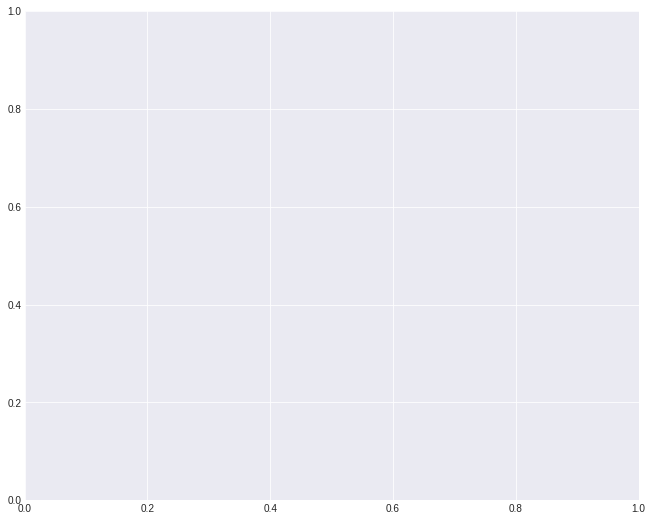

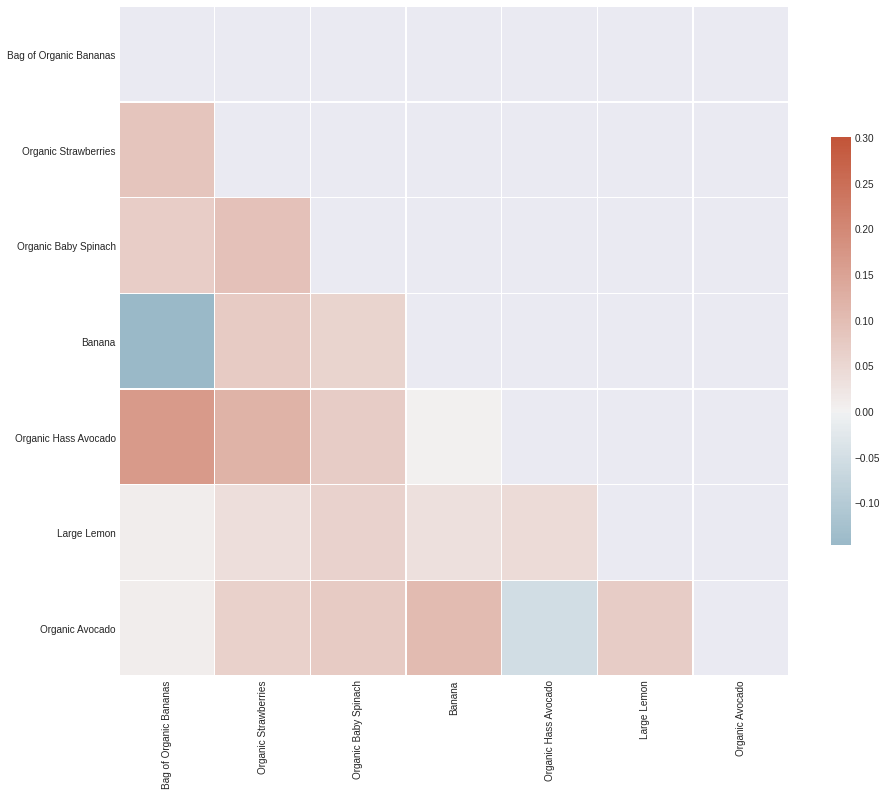

In [42]:
# Compute the correlation matrix
corr = products_for_string.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=(15,15))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig("corr_matrix.png")


In [50]:
chord_plot(products_for_string, popular_prods, width=1000)




## Making a word cloud

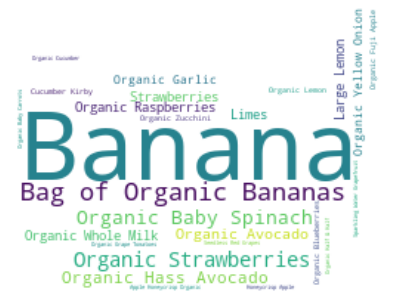

In [8]:
desc_product_count_df.Order_count
ranked_products = list(desc_product_count_df.index.values)

product_sub = desc_product_count_df.head(50)
freq_dict_or = product_sub.to_dict()
freq_dict = freq_dict_or['Order_count']

mask = np.array(Image.open('images/download.jpeg'))
wc = WordCloud(
    stopwords = STOPWORDS, mask=mask, width=mask.shape[1],
               height=mask.shape[0],background_color="white", max_font_size=256,)

wc.generate_from_frequencies(freq_dict)
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.savefig('wordcloud.png')

plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('wordcloud.png')

# plt.show()

## Barplot with product frequencies


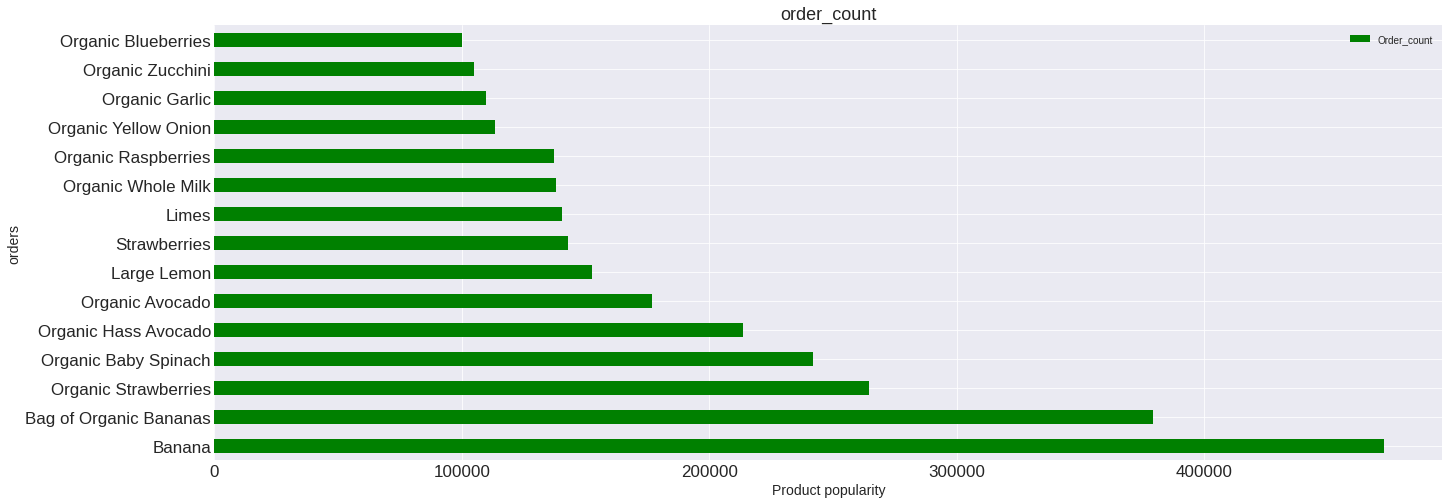

In [9]:
bar_plot(product_sub.iloc[0:15,:], "Product popularity", "orders", 'order_count')
plt.savefig("barplot.png")

## Predicting customer demand

### preprocess

In [9]:
product_prior_comb = order_prior.set_index('product_id').join(product_comb, how="inner")
product_count_df = product_prior_comb.groupby('product_name').product_name.count()
product_count_df = product_count_df.to_frame()
product_count_df = product_count_df.rename(columns={'product_name': 'Order_count'})
desc_product_count_df = product_count_df.sort_values(by=['Order_count'], ascending=False)
product_train_comb = order_train.set_index('product_id').join(product_comb, how="inner")
print(product_prior_comb.shape, product_train_comb.shape)
product_train_comb.head(3)
orders_train_filter = (orders['eval_set']=='train')
orders_test_filter = (orders['eval_set']=='test')
train_set = orders[orders_train_filter]
test_set = orders[orders_test_filter]
orders_product_train_comb = train_set.reset_index().set_index(
    'order_id').join(product_train_comb.set_index('order_id'), how="inner")

# Join with test set creates no data
# orders_product_test_comb = test_set.reset_index().set_index(
#     'order_id').join(product_prior_comb.set_index('order_id'), how="inner")
orders_product_train_comb.head()

NameError: name 'product_prior' is not defined

In [ ]:
last_limit_train = 1000000
#last_limit_train = -1
nearest_neighbour_count=100

# Get the x_train and y_train data arrays from the orders_product_train_comb data frame

X_train = np.array([orders_product_train_comb.loc[:last_limit_train,'order_number'], 
                    orders_product_train_comb.loc[:last_limit_train,'order_dow'], 
                    orders_product_train_comb.loc[:last_limit_train,'order_hour_of_day'],
                    orders_product_train_comb.loc[:last_limit_train,'days_since_prior_order']
                   ])
print(X_train)
orders_product_train_comb_or = orders_product_train_comb
print(orders_product_train_comb_or.columns)
orders_product_train_comb =orders_product_train_comb.select_dtypes(np.number)
X_train = np.array(orders_product_train_comb.loc[:last_limit_train, orders_product_train_comb.columns != 'reordered'])



# To ensure the dimension of the data is last_limit_train rows and four rows
#X_train = np.transpose(X_train)
y_train = np.array(orders_product_train_comb.loc[:last_limit_train,'reordered'])

print(X_train.shape)
print(y_train.shape)

neigh = KNeighborsClassifier(n_neighbors=nearest_neighbour_count)
# Train the knearest neighbours classifier
neigh.fit(X_train, y_train)

# Checking a random row for prediction accuracy

print(orders_product_train_comb.columns)

# print(("Actual Reorder status for product " 
#          + str(orders_product_train_comb.iloc[out_row, 11]) + ' for user ' \
#        + str(orders_product_train_comb.iloc[out_row, 0]) + " is "+str(orders_product_train_comb.iloc[out_row, 7])),
#       orders_product_train_comb.iloc[out_row, :], sep='\n\n')

print(orders_product_train_comb_or.columns)


desired_users = list(set(orders_product_train_comb.loc[:10000,'user_id']))
keep_user = {}
for user in desired_users:
    count_high = 0
    count_low = 0
    predictions = {}
    for out_row in range(10000):
        user_id = orders_product_train_comb.iloc[out_row].loc['user_id']


        if user_id == user:
            out = [orders_product_train_comb.iloc[out_row].loc[orders_product_train_comb.columns != 'reordered']]
            name_row = orders_product_train_comb_or.iloc[out_row].loc['product_name']
            class_row =  neigh.predict(out)
            prob_row = neigh.predict_proba(out)[0][1]
            predictions[name_row] = [class_row, prob_row]

    print("items that will be ordered")       
    #for key,value in predictions.items():
        #print(key,value)
#         if value[0]:
#             print(key)


    print("items that will be ordered with high certainty")       
    for key,value in predictions.items():
        if  value[1]>0.7 or value[1]<0.3:
            #print(key)
            count_high+=1

    print("items that will be ordered with lo2 certainty")       
    for key,value in predictions.items():
        if value[1]<0.6 and value[1]>0.4:
            #print(key)
            count_low+=1
            
    if count_low>1 and count_high >1:
        keep_user[user] = predictions
        print(keep_user)
        
print(keep_user)

max_len = 0
for key,value in keep_user.items():
    if len(value) > max_len:
        max_len=len(value)
        max_user = key
        
print(max_user)
products = keep_user[max_user]
print(products)
print(y_train)

high = []
low = []
for key, value in products.items():
    if value[1] > 0.7:
        high.append(key)
    elif value[1] < 0.6:
        low.append(key)
        
print("If all", products.values())
print("If high ", high)
print("If low ", low)

## Simpson's paradox

In [28]:
# rank all products
product_comb = products.reset_index().set_index('department_id').join(departments, how="inner")
product_comb = product_comb.reset_index().set_index('aisle_id').join(aisle, how="inner")
product_comb = product_comb.reset_index().set_index('product_id')
product_comb.sort_index(axis=0, ascending=True, kind='quicksort', inplace=True)
product_prior_comb = order_prior.set_index('product_id').join(product_comb, how="inner")
product_count_df = product_prior_comb.groupby('product_name').product_name.count()



# rank all night products

In [58]:
print(product_comb.head())

print(product_count_df.head())

# rank all day products
print(product_prior_comb.columns)
print(order_prior.columns)
print("orderes")
print(orders.head())
product_comb_time = product_prior_comb.reset_index().set_index('order_id').join(orders, how="inner")
product_comb_time = product_comb_time.reset_index().set_index('product_id')
# order_prior_time = order_prior.set_index('product_id').join(orders, how="inner")
# print(order_prior_time.columns)
# product_prior_comb = order_prior_time.set_index('product_id').join(product_comb, how="inner")
print(product_comb_time.columns)
print(product_comb_time.head())
product_prior_comb_day = product_comb_time[product_comb_time["order_hour_of_day"] < 18]
print("during day")

print(product_prior_comb_day.head())

product_count_df_day = product_prior_comb_day.groupby('product_name').product_name.count()
print(product_count_df_day.head())
print(product_count_df.head())
product_prior_comb_night = product_comb_time[product_comb_time["order_hour_of_day"] >= 18]
product_count_df_night = product_prior_comb_night.groupby('product_name').product_name.count()
print(product_count_df_night.head())

            aisle_id  department_id  \
product_id                            
1                 61             19   
2                104             13   
3                 94              7   
4                 38              1   
5                  5             13   

                                                 product_name department  \
product_id                                                                 
1                                  Chocolate Sandwich Cookies     snacks   
2                                            All-Seasons Salt     pantry   
3                        Robust Golden Unsweetened Oolong Tea  beverages   
4           Smart Ones Classic Favorites Mini Rigatoni Wit...     frozen   
5                                   Green Chile Anytime Sauce     pantry   

                                 aisle  
product_id                              
1                        cookies cakes  
2                    spices seasonings  
3                            

In [62]:
def simpsons(total_1, total_2, a1, a2, b1, b2, numa, numb):
    result = [0,0]
    perca1 = a1/numa
    perca2 = a2/numa
    percb1 = b1/numb
    percb2 = b2/numb
    total_1 = total_1/(numa+numb)
    total_2 = total_2/(numa+numb)
    if perca1 < perca2:
        result[0] = 2
    if percb1 < percb2:
        result[1] = 2
    
    if result[0]== result[1]==1:
        product = 1
    elif result[0]== result[1]==2:
        product = 2
    else:
        product = 0
    
    if total_1 > total_2:
        total = 1
    else:
        total = 2
    
    if total!=product and product!=0:
        print(total_1, total_2, perca1,perca2,percb1,percb2, numa, numb)

        return True
    else:
        return False
    
    

In [63]:
print(product_count_df_day)
day_dict = product_count_df_day.to_dict()
#product_count_df_day.to_dict()
night_dict = product_count_df_night.to_dict()
total_dict = product_count_df.to_dict()
nday_orders = len(product_prior_comb_day)
nnight_orders = len(product_prior_comb)
ntotal_orders = len(product_prior_comb)

print(len(day_dict.values()))
print(len(night_dict.values()))

counter=0
keep_dilemmas = []
for key_1, t_value_1 in total_dict.items():
    for key_2, t_value_2 in total_dict.items():
        if key_1 != key_2:
            if counter <1:
                if key_1 in day_dict.keys():
                    d_value_1 = day_dict[key_1]
                else:
                    d_value_1 = 0
                if key_2 in day_dict.keys():
                    d_value_2 = day_dict[key_2]
                else:
                    d_value_2 = 0

                if key_1 in night_dict.keys():
                    n_value_1 = night_dict[key_1]
                else:
                    n_value_1 = 0

                if key_2 in night_dict.keys():
                    n_value_2 = night_dict[key_2]
                else:
                    n_value_2 = 0


                if simpsons(t_value_1, t_value_2,d_value_1,d_value_2,n_value_1,n_value_2, nday_orders,nnight_orders):
                    keep_dilemmas.append([key_1, key_2])
                    print(d_value_1, n_value_1, d_value2, n_value_2)
                    counter+=1
                    print("bump")
                    print(key_1, key_2)
            
            
print(keep_dilemmas)



product_name
#2 Coffee Filters                                                  657
#2 Cone White Coffee Filters                                        11
#2 Mechanical Pencils                                                7
#4 Natural Brown Coffee Filters                                    208
& Go! Hazelnut Spread + Pretzel Sticks                             143
                                                                  ... 
with Xylitol Unwrapped Original Flavor 50 Sticks Sugar Free Gum     30
with Xylitol Unwrapped Spearmint 50 Sticks Sugar Free Gum           45
with Xylitol Watermelon Twist 18 Sticks Sugar Free Gum              56
with a Splash of Mango Coconut Water                                21
with a Splash of Pineapple Coconut Water                            47
Name: product_name, Length: 49631, dtype: int64
49631
46517
[]


In [56]:
print(keep_dilemmas)

[['#2 Coffee Filters', 'White Cannellini Kidney Beans']]


In [33]:
print(total_dict["#2 Coffee Filters"])

777


In [53]:
print(night_dict["#2 Coffee Filters"])
print(day_dict["#2 Coffee Filters"])
print(product_count_df_night["#2 Coffee Filters"])

print(night_dict["Buffalo Chicken Wings"])
print(day_dict["Buffalo Chicken Wings"])
print(product_count_df_night["Buffalo Chicken Wings"])

print(product_count_df_night.head())
print(night_dict["#4 Natural Brown Coffee Filters"])



120
657
120
131
652
131
product_name
#2 Coffee Filters                         120
#2 Cone White Coffee Filters                2
#2 Mechanical Pencils                       1
#4 Natural Brown Coffee Filters            33
& Go! Hazelnut Spread + Pretzel Sticks     21
Name: product_name, dtype: int64
33
